In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import numpy as np
import pandas as pd
import xarray as xr

# Advect Rain

This notebook walks through the steps for solving a pure advection problem using a real-world radar reflectivity field and an assumed flow field.

## Data Prep

Most of the data here is already ready to go. However, we do need to re-grid the HRRR output to match the radar reflectivity field we want to use. That methodology is documented here.

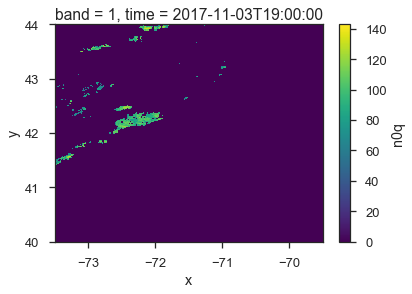

In [10]:
refl = xr.open_dataarray("data/boston_nov_3/n0q.subset.nc").squeeze()
refl = refl.transpose('time', 'x', 'y')
# refl = refl.isel(x=slice(100, 700))

refl.isel(time=0).plot.imshow('x', 'y')

u = np.ones_like(refl.isel(time=0))*10
v = np.ones_like(refl.isel(time=0))*0

Derive reflectivity from the encoded `n0q` dataset, and set algorithm parameters.

In [3]:
from ccpy.obs import n0q_to_refl

q0 = n0q_to_refl(refl.isel(time=0)).values
q0[np.isnan(q0)] = 0.
print(q0.shape)

x = refl.x.values
y = refl.y.values

Δx = (x[1] - x[0])*6.371e6/360
Δy = (y[1] - y[0])*6.371e6/360

(801, 801)


Apply the first order, upwind Euler advection scheme to solve the problem.

In [9]:
v_pos_mask = v > 0
u_pos_mask = u > 0

q = q0.copy()
yy = 35
Δt = 300.0 / yy
print(Δt)
print((u.max() * Δt / Δx + v.max() * Δt / Δy))
print(q.max())

def deriv(q, u=u, v=v, Δx=Δx, Δy=Δy):

    _q = q.copy()
    
    dq_x_neg = _q[1:-1, 1:-1] - _q[ :-2, 1:-1]
    dq_x_pos = _q[2:,   1:-1] - _q[1:-1, 1:-1] 
    dq_y_neg = _q[1:-1, 1:-1] - _q[1:-1,  :-2]
    dq_y_pos = _q[1:-1,   2:] - _q[1:-1, 1:-1]
    
    u_pos = np.maximum(u, 0)[1:-1, 1:-1]
    u_neg = np.minimum(u, 0)[1:-1, 1:-1]
    v_pos = np.maximum(v, 0)[1:-1, 1:-1]
    v_neg = np.minimum(v, 0)[1:-1, 1:-1]
    
    dq_x = (u_pos * dq_x_neg) + (u_neg * dq_x_pos)
    dq_y = (v_pos * dq_y_neg) + (v_neg * dq_y_pos)
    
    return dq_x/Δx + dq_y/Δy

qs = [q, ]
ts = [0, ]

oc = 0
t = 0 
for i in range(12 * yy):
    
    q_new = np.zeros_like(q)
    q_int = q[1:-1, 1:-1]
    q_new[1:-1, 1:-1] = q_int - Δt*deriv(q)
        
    q = q_new.copy()
    t += Δt
    
    if ((i+1) % yy) == 0:
        oc += 1
        qs.append(q)
        ts.append(t)
        print(oc, t, q.max(), deriv(q).max())
    
qs = np.asarray([q.T for q in qs])
ts = np.asarray(ts)

8.571428571428571
0.968675022984
39.5
1 300.00000000000006 39.3266261916 1.45331489711
2 599.9999999999995 38.6487213669 0.943770214839
3 899.999999999999 37.7978525166 0.739538552897
4 1200.0000000000007 37.1221946895 0.641806413831
5 1500.000000000004 36.5097472583 0.557845467361
6 1800.0000000000075 35.8743843721 0.486004765526
7 2100.0000000000095 35.222624712 0.424972343545
8 2400.000000000005 34.6631160058 0.402735298607
9 2700.0000000000005 34.1695299022 0.392484400477
10 2999.999999999996 33.6629993215 0.382243769345
11 3299.9999999999914 33.3327943002 0.372012405299
12 3599.999999999987 33.2825892407 0.361784614353


In [13]:
ds = xr.Dataset(
    {'q': (('time', 'y', 'x'), qs),
     'u': (('y', 'x'), u),
     'v': (('y', 'x'), v)},
    {'time': ts, 'x': x, 'y': y},
)
ds['time'].attrs.update({'long_name': 'time', 'units': 'seconds since 2000-01-01 0:0:0'})
ds['x'].attrs.update({'long_name': 'x-coordinate', 'units': 'm'})
ds['y'].attrs.update({'long_name': 'y-coordinate', 'units': 'm'})
ds['u'].attrs.update({'long_name': 'zonal wind', 'units': 'm/s'})
ds['v'].attrs.update({'long_name': 'meridional wind', 'units': 'm/s'})
ds.attrs.update({
    'Conventions': 'CF-1.7'
})

ds.to_netcdf('test.real1.nc')

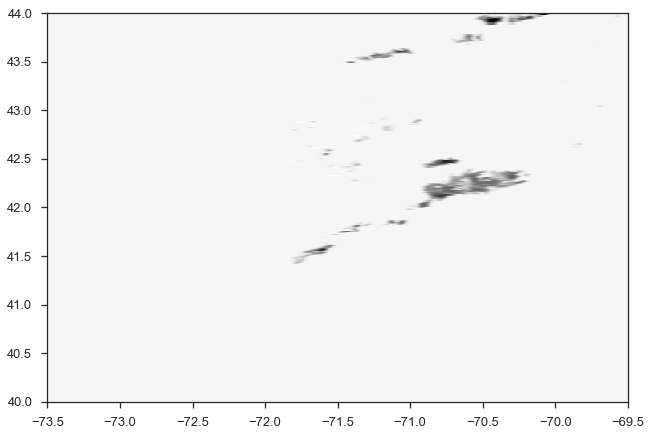

In [88]:
plt.pcolormesh(x, y, qs[10].T)

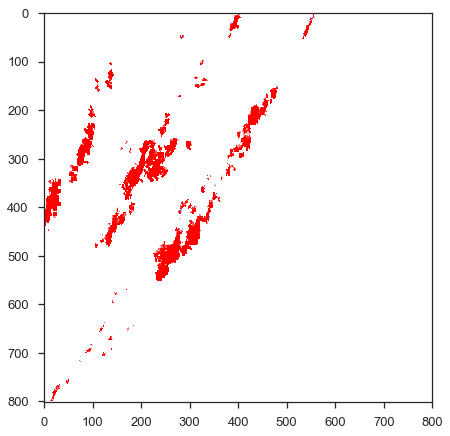

In [95]:
ii = 8

tt = n0q_to_refl(refl.isel(time=ii)).values
plt.imshow(tt - q[ii], vmin=-10, vmax=10, cmap='bwr')

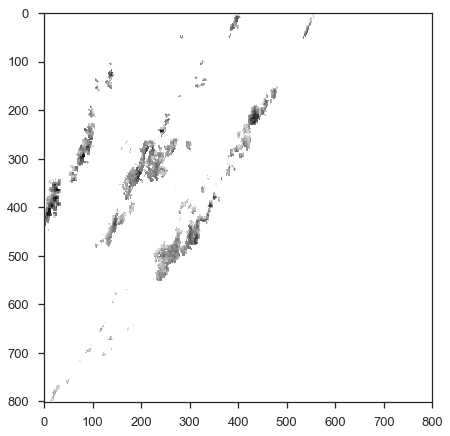

In [97]:
plt.imshow(tt)